In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/chengpeng/Desktop/Research/STAT/CIBer')
import comonotonic as cm
import ensemble_ciber as ec
import math
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import copy
import tool_box as tb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import ensemble_ciber as ec
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTENC
import xlsxwriter

/home/r7user5/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('oil_spill.csv')
df.drop(df.columns[[0,22]], axis = 1, inplace=True)

In [3]:
colnames = [('X'+str(i)) for i in range(df.shape[1]-1)]
colnames.append('Y')
df.columns = colnames

In [4]:
categorical = []
cont_col = [i for i in range(df.shape[1]-1)]
discrete_feature_val = None

In [5]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['Y']])

In [6]:
scaler = preprocessing.StandardScaler()
scale_col_name = ["X"+str(i) for i in cont_col]
df_train[scale_col_name] = scaler.fit_transform(df_train[scale_col_name])
reduced_df_train = tb.outlier_removal(df_train, cont_col)
df_test[scale_col_name] = scaler.transform(df_test[scale_col_name])

/home/r7user5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/home/r7user5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [7]:
x_train = reduced_df_train.iloc[:,:-1].to_numpy()
y_train = reduced_df_train.iloc[:,-1].to_numpy()
smote = SMOTE(random_state=0)
x_train_synthetic, y_train_synthetic = smote.fit_resample(x_train, y_train)

In [8]:
x_test = df_test.iloc[:,:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [9]:
np.unique(y_test, return_counts = True)

(array([0, 1]), array([270,  12]))

In [10]:
sample_percentage = math.sqrt(x_train.shape[1])/x_train.shape[1]

In [9]:
cf = ec.ciber_forest(n_estimators = 100, max_workers = 30, sample_percentage = sample_percentage)
cf.fit(x_train,y_train,discrete_feature_val,cont_col,categorical, 0.96, None, 
       corrtype='mutual_info',discrete_method='mdlp')
cf_predict = cf.predict(x_test)
print(classification_report(y_test, cf_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       178
           1       0.99      0.96      0.97       181

    accuracy                           0.97       359
   macro avg       0.98      0.98      0.97       359
weighted avg       0.98      0.97      0.97       359



In [ ]:
ciber = cm.clustered_comonotonic(x_train_synthetic,y_train_synthetic,
                                 discrete_feature_val,cont_col,categorical, 
                                 0.99, None, corrtype='mutual_info',
                                 discrete_method='mdlp')
ciber.run()
ciber_predict = ciber.predict(x_test)
print(classification_report(y_test,ciber_predict))

In [15]:
ciber.print_cluster()

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20, 22, 24], [21], [23], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36, 37], [38], [39], [40], [41], [42], [43], [44], [45], [46]]


In [19]:
clusters = [[0], [1, 2, 5, 15, 44], [3], [4], [6], [7], [8], [9], [10], [11], [12], [13], [14], [16], [17], [18], [19], [20, 22, 24, 36, 37], [21], [23], [25], [26], [27], [28], [29, 31], [30], [32], [33], [34], [35], [38], [39], [40], [41], [42], [43], [45], [46]]
useful_clusters = [i for i in clusters if len(i) > 1]

In [27]:
training = np.concatenate((x_train_synthetic,y_train_synthetic.reshape(-1,1)), axis=1)
sync_df = pd.DataFrame(training)
sync_df.columns = colnames

/home/r7user5/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/home/r7user5/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


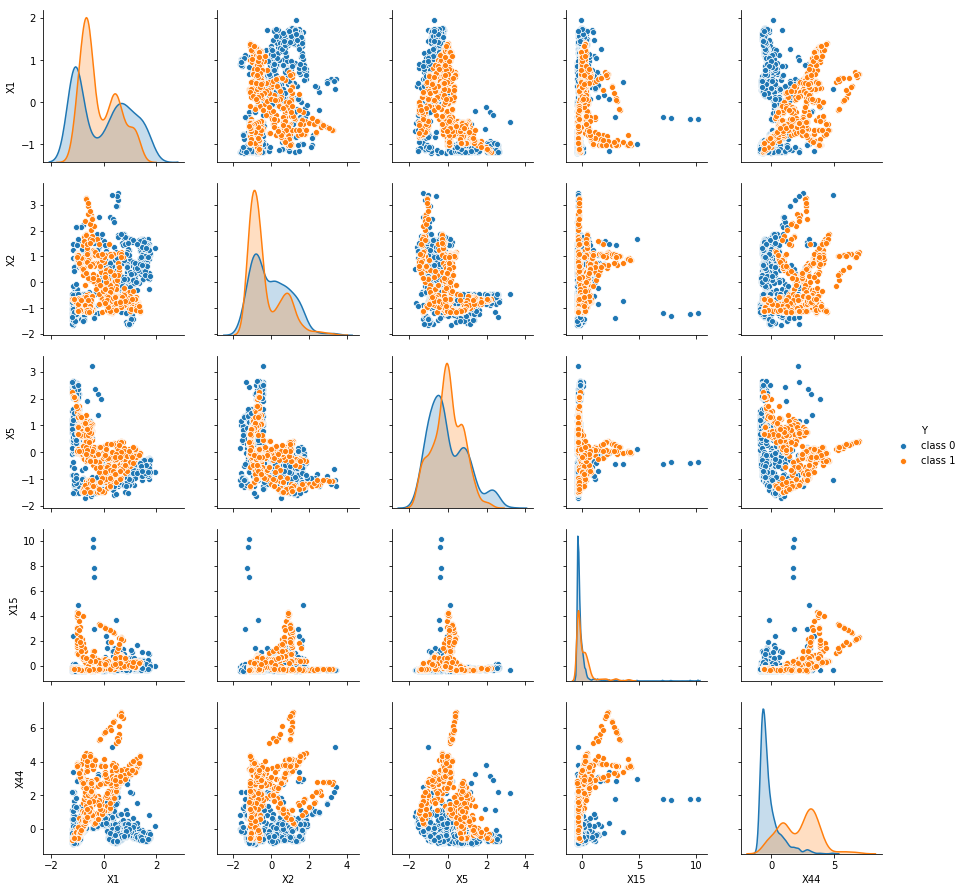

In [35]:
df_4_plot = sync_df.iloc[:,useful_clusters[0]+[47]]
df_4_plot["Y"].replace({0:'class 0', 1:'class 1'}, inplace = True)
sns.pairplot(df_4_plot,hue='Y')

In [17]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(x_train_synthetic,y_train_synthetic)
xgb_predict = xgb_clf.predict(x_test)
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       270
           1       0.50      0.58      0.54        12

    accuracy                           0.96       282
   macro avg       0.74      0.78      0.76       282
weighted avg       0.96      0.96      0.96       282



In [18]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_synthetic,y_train_synthetic)
rf_predict = rf_clf.predict(x_test)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       270
           1       0.35      0.50      0.41        12

    accuracy                           0.94       282
   macro avg       0.67      0.73      0.69       282
weighted avg       0.95      0.94      0.94       282



/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
DT_clf = tree.DecisionTreeClassifier()
DT_clf.fit(x_train_synthetic,y_train_synthetic)
DT_predict = DT_clf.predict(x_test)
print(classification_report(y_test, DT_predict))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       270
           1       0.17      0.25      0.20        12

    accuracy                           0.91       282
   macro avg       0.57      0.60      0.58       282
weighted avg       0.93      0.91      0.92       282



In [28]:
svm = SVC(probability = True)
svm.fit(x_train_synthetic, y_train_synthetic)
svm_predict = svm.predict(x_test)
print(classification_report(y_test, svm_predict))

/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.93      0.96       270
           1       0.33      0.75      0.46        12

    accuracy                           0.93       282
   macro avg       0.66      0.84      0.71       282
weighted avg       0.96      0.93      0.94       282



In [21]:
lr = LogisticRegression()
lr.fit(x_train_synthetic, y_train_synthetic)
lr_predict = lr.predict(x_test)
print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95       270
           1       0.28      0.83      0.42        12

    accuracy                           0.90       282
   macro avg       0.63      0.87      0.68       282
weighted avg       0.96      0.90      0.92       282



/home/r7user5/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_train_synthetic, y_train_synthetic)
gaussian_nb_predict = gaussian_nb.predict(x_test)
print(classification_report(y_test,gaussian_nb_predict))

              precision    recall  f1-score   support

           0       0.96      0.24      0.38       270
           1       0.04      0.75      0.08        12

    accuracy                           0.26       282
   macro avg       0.50      0.49      0.23       282
weighted avg       0.92      0.26      0.37       282



In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
ciber_probs = ciber.predict_proba(x_test)[:,1]
ciber_fpr, ciber_tpr, _ = roc_curve(y_test, ciber_probs)
ciber_auc = roc_auc_score(y_test, ciber_probs)

nb_probs = gaussian_nb.predict_proba(x_test)[:,1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)

xgb_probs = xgb_clf.predict_proba(x_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

rf_probs = rf_clf.predict_proba(x_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

DT_probs = DT_clf.predict_proba(x_test)[:,1]
DT_fpr, DT_tpr, _ = roc_curve(y_test, DT_probs)
DT_auc = roc_auc_score(y_test, DT_probs)

svm_probs = svm.predict_proba(x_test)[:,1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = roc_auc_score(y_test, svm_probs)

lr_probs = lr.predict_proba(x_test)[:,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [30]:
base_probs = [0 for _ in range(len(y_test))]
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)

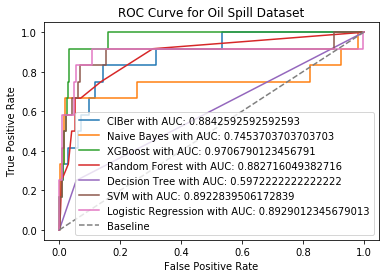

In [31]:
plt.plot(ciber_fpr, ciber_tpr, label='CIBer with AUC: ' + str(ciber_auc))
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes with AUC: ' + str(nb_auc))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost with AUC: ' + str(xgb_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest with AUC: ' + str(rf_auc))
plt.plot(DT_fpr, DT_tpr, label='Decision Tree with AUC: ' + str(DT_auc))
plt.plot(svm_fpr, svm_tpr, label='SVM with AUC: ' + str(svm_auc))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression with AUC: ' + str(lr_auc))
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')

plt.title("ROC Curve for Oil Spill Dataset")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC Curve.png', format='png', dpi=1200)